In [1]:
from sklearn.linear_model import LinearRegression
import pickle
import numpy as np
import glob

import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# load simulation data 
data_folder = "E:\\Holography\\lat_holocal\\data\\ctcheung\\2022_02_10_13_52\\"
sim_files = glob.glob(data_folder+"*.pys")
dataset_size = len(sim_files)
dataset = dict(adj_err_1=[], adj_err_2=[], field_fp=[])
for simfile in sim_files:
    with open(simfile, "rb") as file:
        sim_data = pickle.load(file)
    dataset["adj_err_1"].append(sim_data["adj_err_1"])
    dataset["adj_err_2"].append(sim_data["adj_err_2"])
    dataset["field_fp"].append(sim_data["field_fp"])
print(len(dataset["field_fp"]))


1000


In [32]:
# ########### copy from script_backup.py
# scanning plane
index = 10
Npts_x = np.shape(dataset["field_fp"][index])[0]
Npts_z = np.shape(dataset["field_fp"][index])[1]
scanrange_x = 800 # [mm]
scanrange_z = 800 # [mm]
P_rx_x = np.linspace(-scanrange_x/2.0, scanrange_x/2.0, Npts_x)
P_rx_y = 209.920654 # mm, position of focus point with rf source located 1km away
P_rx_z = np.linspace(-scanrange_z/2.0, scanrange_z/2.0, Npts_z)

rx_x_grid, rx_z_grid = np.meshgrid(P_rx_x, P_rx_z)
fp_field = dataset["field_fp"][index]
hole_radius = 30 # [mm]
P_rx_r = np.sqrt(rx_x_grid*rx_x_grid + rx_z_grid*rx_z_grid)
fp_field = np.where(P_rx_r>hole_radius, fp_field , 0)

Here we perform a FFT to the simulation data

In [33]:
# fftd = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(dataset["field_fp"][0])))
# fp_field = dataset["field_fp"][0]
ap_field = fp_field
# ap_field = np.fft.fftshift(np.fft.ifft2(fp_field))
ampl = np.abs(ap_field)
# valid = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.3)
# print(np.shape(valid))
# ap_field = np.where(
#     (abs(ampl) / np.max(abs(ampl))) >= 0.05, ap_field, 0
# )



############# plot the field #######################################
import plotly.graph_objects as go
x = P_rx_x/470.0*6000.0 # manual scaling approx.
y = P_rx_z/470.0*6000.0 # manual scaling approx.
field_complex = ap_field / np.max(np.abs(ap_field)) # normalize the field

plot_1 = go.Heatmap(
                    x=x, 
                    y=y,
                    z = np.angle(field_complex),
                    colorscale='Twilight',
                    showscale=True, colorbar=dict(len=0.8, x=0.44),
                    showlegend = False,
                    # hoverinfo='name', 
                    name="phase"
                    )
plot_2 = go.Heatmap( 
                    x=x, 
                    y=y,
                    z = 20*np.log10(np.abs(field_complex)),
                    # z= np.abs(field_fp*field_fp),
                    colorscale='Magma',
                    showscale=True, 
                    colorbar=dict(len=0.8, x=1), 
                    showlegend = False,
                    # hoverinfo='name', 
                    name="power"
                    )
layout = go.Layout(title='Beam on aperture plane', autosize=True,
                width=1000, height=500, 
                margin=dict(l=50, r=50, b=65, t=90),
                xaxis1 = dict(title="x [mm]"),
                yaxis1 = dict(scaleanchor = 'x', title="y [mm]"),
                xaxis2 = dict(scaleanchor = "x", title="x [mm]"),
                yaxis2 = dict(scaleanchor = "y"),
                )

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2, shared_yaxes=False, shared_xaxes=True, subplot_titles=["Phase (FFT) [rad]", "Intensity (FFT) [dB]"])
fig.add_trace(plot_1, row=1, col=1)
fig.add_trace(plot_2, row=1, col=2)
fig.update_layout(layout)
fig.show()


D:\ProgramData\Miniconda3\envs\holoenv\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log10



In [5]:
# set the sizes of training and testing sets
N_train = int(dataset_size*0.9)
N_test = dataset_size - N_train
print(f"Size of Training set : {N_train}")
print(f"Size of Testing set : {N_test}")

# shuttle data set
shuffler = np.random.permutation(dataset_size)
dataset["adj_err_1"] = np.array(dataset["adj_err_1"])[shuffler]
dataset["adj_err_2"] = np.array(dataset["adj_err_2"])[shuffler]
dataset["field_fp"] = np.array(dataset["field_fp"])[shuffler]

# construct training set
train_input = []
train_output = []
for adj_m1, adj_m2 in zip(dataset["adj_err_1"][:N_train], dataset["adj_err_2"][:N_train]):
    train_output.append(np.concatenate((adj_m1, adj_m2)))
    # print(adj_m1, adj_m2)
for field in dataset["field_fp"][:N_train]:
    field = np.where(P_rx_r>hole_radius, field , 0)
    # ampl = np.abs(field)
    # field = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.05, field, 0)

    #### with FFT
    ap_field = np.ravel(np.fft.ifft2(field))
    ampl = np.abs(ap_field)
    phase = np.angle(ap_field)
    # print( np.shape(np.where(
    #     (abs(ampl) / np.max(abs(ampl))) >= 0.3)))
    phase = np.where(
        (abs(ampl) / np.max(abs(ampl))) >= 0.05, phase-np.mean(phase), 0
    )
    train_input.append(phase)

    # #### without FFT
    # phase = np.ravel(np.angle(field))
    # # ampl = np.abs(np.ravel(field))
    # # phase = np.where(
    # #     (abs(ampl) / np.max(abs(ampl))) >= 0.3, phase-np.mean(phase), 0
    # # )
    # # phase_wrap = phase + np.pi
    # # train_input.append(np.concatenate((phase, phase_wrap)))
    # train_input.append(phase)
    
# construct testing set
test_input = []
test_output = []
for adj_m1, adj_m2 in zip(dataset["adj_err_1"][N_train:], dataset["adj_err_2"][N_train:]):
    test_output.append(np.concatenate((adj_m1, adj_m2)))
for field in dataset["field_fp"][N_train:]:
    field = np.where(P_rx_r>hole_radius, field , 0)
    # ampl = np.abs(field)
    # field = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.05, field, 0)

    #### with FFT
    ap_field = np.ravel(np.fft.ifft2(field))
    ampl = np.abs(ap_field)
    phase = np.angle(ap_field)
    phase = np.where(
        (abs(ampl) / np.max(abs(ampl))) >= 0.05, phase-np.mean(phase), 0
    )
    test_input.append(phase)

    # #### without FFT
    # phase = np.ravel(np.angle(field))
    # # ampl = np.abs(np.ravel(field))
    # # phase = np.where(
    # #     (abs(ampl) / np.max(abs(ampl))) >= 0.3, phase-np.mean(phase), 0
    # # )
    # # phase_wrap = phase + np.pi
    # # test_input.append(np.concatenate((phase, phase_wrap)))
    # test_input.append(phase)
    
N_features = np.shape(test_output)[1]

# Train the linear regression ML model
model_lr = LinearRegression(n_jobs=-1)  # Define ML algorithm
model_lr.fit(train_input, train_output)  # Train model with training datasets
# Save the model
filename_si = "model_singular1.sav"
pickle.dump(model_lr, open(filename_si, "wb"))
print("Linear regression model trained and saved!")



Size of Training set : 900
Size of Testing set : 100
Linear regression model trained and saved!


In [6]:
hole_radius = 25 # [mm]
def train_model_holesize(holesize):
    shuffler = np.random.permutation(dataset_size)
    dataset["adj_err_1"] = np.array(dataset["adj_err_1"])[shuffler]
    dataset["adj_err_2"] = np.array(dataset["adj_err_2"])[shuffler]
    dataset["field_fp"] = np.array(dataset["field_fp"])[shuffler]
    hole_radius = holesize
    train_input = []
    print(f"!!! Hole radius : {hole_radius} mm-------------------------")
    for field in dataset["field_fp"][:N_train]:
        field = np.where(P_rx_r>hole_radius, field , 0)
        # ampl = np.abs(field)
        # field = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.05, field, 0)

        #### with FFT
        ap_field = np.ravel(np.fft.ifft2(field))
        ampl = np.abs(ap_field)
        phase = np.angle(ap_field)
        # print( np.shape(np.where(
        #     (abs(ampl) / np.max(abs(ampl))) >= 0.3)))
        phase = np.where(
            (abs(ampl) / np.max(abs(ampl))) >= 0.05, phase-np.mean(phase), 0
        )
        train_input.append(phase)
    test_input = []
    for field in dataset["field_fp"][N_train:]:
        field = np.where(P_rx_r>hole_radius, field , 0)
        # ampl = np.abs(field)
        # field = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.05, field, 0)

        #### with FFT
        ap_field = np.ravel(np.fft.ifft2(field))
        ampl = np.abs(ap_field)
        phase = np.angle(ap_field)
        phase = np.where(
            (abs(ampl) / np.max(abs(ampl))) >= 0.05, phase-np.mean(phase), 0
        )
        test_input.append(phase)

    # Train the linear regression ML model
    model_lr = LinearRegression(n_jobs=-1)  # Define ML algorithm
    model_lr.fit(train_input, train_output)  # Train model with training datasets

    model_score = model_lr.score(test_input, test_output)
    print(f"Model score (from testing set): {model_score}")

    # Save the model
    filename_si = f"E:\\Holography\\lat_holocal\\data\\ctcheung\\model\\model_LR_{hole_radius}.sav"
    pickle.dump(model_lr, open(filename_si, "wb"))
    print(f"Linear regression model for holesize{hole_radius} trained and saved!")
    return model_score
modelscore_list = []
holesize_list = [0.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0, 90.0, 150.0, 240.0]
for hs in holesize_list:
    model_score = train_model_holesize(hs)
    modelscore_list.append(model_score)

!!! Hole radius : 0.0 mm-------------------------
Model score (from testing set): 0.008775531420501163
Linear regression model for holesize0.0 trained and saved!
!!! Hole radius : 5.0 mm-------------------------
Model score (from testing set): 0.15664275643413075
Linear regression model for holesize5.0 trained and saved!
!!! Hole radius : 10.0 mm-------------------------
Model score (from testing set): 0.18692410286751923
Linear regression model for holesize10.0 trained and saved!
!!! Hole radius : 15.0 mm-------------------------
Model score (from testing set): 0.2242576724078718
Linear regression model for holesize15.0 trained and saved!
!!! Hole radius : 20.0 mm-------------------------
Model score (from testing set): 0.23862739828742044
Linear regression model for holesize20.0 trained and saved!
!!! Hole radius : 30.0 mm-------------------------
Model score (from testing set): 0.22921429101659252
Linear regression model for holesize30.0 trained and saved!
!!! Hole radius : 50.0 mm-

In [18]:
holesize_list2 = [300.0, 340.0, 360.0, 380.0, 390.0, 395.0, 400.0]
for hs in holesize_list2:
    model_score = train_model_holesize(hs)
    modelscore_list.append(model_score)

!!! Hole radius : 300.0 mm-------------------------
Model score (from testing set): 0.18356557716279062
Linear regression model for holesize300.0 trained and saved!
!!! Hole radius : 340.0 mm-------------------------
Model score (from testing set): 0.1690085935774151
Linear regression model for holesize340.0 trained and saved!
!!! Hole radius : 360.0 mm-------------------------
Model score (from testing set): 0.16211589933884793
Linear regression model for holesize360.0 trained and saved!
!!! Hole radius : 380.0 mm-------------------------
Model score (from testing set): 0.14999604616327655
Linear regression model for holesize380.0 trained and saved!
!!! Hole radius : 390.0 mm-------------------------
Model score (from testing set): 0.14397391055761227
Linear regression model for holesize390.0 trained and saved!
!!! Hole radius : 395.0 mm-------------------------
Model score (from testing set): 0.13544996666116055
Linear regression model for holesize395.0 trained and saved!
!!! Hole ra

[  0.   5.  10.  15.  20.  30.  50.  90. 150. 240. 300. 340. 360. 380.
 390. 395. 400.]
[0.00877553 0.15664276 0.1869241  0.22425767 0.2386274  0.22921429
 0.2225191  0.21978219 0.20861317 0.2023211  0.18356558 0.16900859
 0.1621159  0.14999605 0.14397391 0.13544997 0.13473267]


Text(0, 0.5, 'score (0 to 1)')

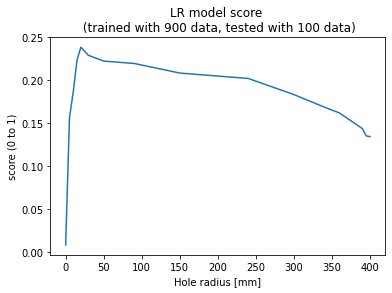

In [23]:
hole_size = np.array(holesize_list + holesize_list2)
model_score = np.array(modelscore_list)
print(hole_size)
print(model_score)
x = hole_size
y = model_score
plt.plot(x, y)
plt.title("LR model score \n (trained with 900 data, tested with 100 data)")
plt.xlabel("Hole radius [mm]")
plt.ylabel("score (0 to 1)")

Model score (from training set) : 1.0
Model score (from testing set): 0.2269479698553976
average normalized residual: 0.7641153784139412


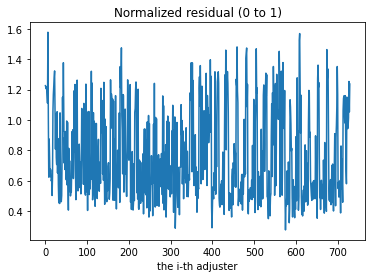

In [7]:
# Load model
filename_si = "model_singular1.sav"
with open(filename_si, "rb") as file:
    model_lr = pickle.load(file)

# print('shape of intercept:', np.shape(model_lr.intercept_))
# print('shape of slope:', np.shape(model_lr.coef_)) 
model_score = model_lr.score(train_input, train_output)
print(f"Model score (from training set) : {model_score}")
model_score = model_lr.score(test_input, test_output)
print(f"Model score (from testing set): {model_score}")

# Make a prediction
predict_output = model_lr.predict(test_input)
residual_normalized = np.mean(np.square(test_output - predict_output), axis=0)/np.mean(np.square(train_output+test_output), axis=0)
# print('shape of predict_output:', np.shape(predict_output)) 
# print('shape of residual:', np.shape(residual_normalized)) 
print('average normalized residual:', np.mean(residual_normalized)) 

import matplotlib.pyplot as plt
plt.title("Normalized residual (0 to 1)")
plt.plot(residual_normalized)
plt.xlabel("the i-th adjuster")
plt.show()


In [8]:
# Import the packages and classes needed in this example:
import numpy as np
from sklearn.linear_model import LinearRegression

# Create a numpy array of data:
x = np.array([6, 16, 26, 36, 46, 56]).reshape((-1, 1))
y = np.array([4, 23, 10, 12, 22, 35])

# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x, y) 

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model.intercept_)

# Print the Slope:
print('slope:', model.coef_) 

# Predict a Response and print it:
y_pred = model.predict(x)
print('Predicted response:', y_pred, sep='\n')

coefficient of determination: 0.5417910447761195
intercept: 4.026666666666664
slope: [0.44]
Predicted response:
[ 6.66666667 11.06666667 15.46666667 19.86666667 24.26666667 28.66666667]


In [36]:
iters = 1000
n_adj_m1 = 5 * 77
n_adj_m2 = 5 * 69
rx_x = np.array([0])
rx_z = np.array([0])
rx3 = np.array([rx_x[0], 209.09, rx_z[0]])

################## initialize plots ##################
layout = go.Layout(title='Beam on sky', autosize=True,
            width=1000, height=500, 
            margin=dict(l=50, r=50, b=65, t=90),
            xaxis1 = dict(title="x [mrad]"),
            yaxis1 = dict(scaleanchor = 'x', title="y [mrad]"),
            xaxis2 = dict(scaleanchor = "x", title="x [mrad]"),
            yaxis2 = dict(scaleanchor = "y"),
            )
fig = make_subplots(rows=1, cols=2, shared_yaxes=False, 
                shared_xaxes=True, subplot_titles=["Phase [rad]", "Intensity [dB]"])
fig.update_layout(layout)


path = "E:\\Holography\\lat_holocal\\data\\chesmore\\sim_out\\rx000pys"
filename_base = "skysim_data"
adj_tot1 = []
data1 = []
iters = 1000
for ii in range(iters):
    dat_C = np.loadtxt(
        "E:\\Holography\\lat_holocal\\data\\chesmore\\sim_out\\rx000\\rx_" + str(rx3) + "_" + str(ii + 1) + ".txt"
    )
    adj_m1 = np.loadtxt(
        "E:\\Holography\\lat_holocal\\data\\chesmore\\sim_out\\rx000\\adj_offsets_m1_" + str(ii + 1) + ".txt"
    )[
        0:n_adj_m1
    ]  # mm

    adj_m2 = np.loadtxt(
        "E:\\Holography\\lat_holocal\\data\\chesmore\\sim_out\\rx000\\adj_offsets_m2_" + str(ii + 1) + ".txt"
    )[
        0:n_adj_m2
    ]  # mm
    
    data1.append(dat_C)
    adj_tot1.append(np.concatenate((adj_m1, adj_m2)))

    nx = len(dat_C[:, 0])
    ny = len(dat_C[:, 1])
    ndat = len(dat_C[0, :])
    azi = dat_C[:, 0]
    az = azi
    eli = dat_C[:, 1]
    el = eli
    beam = dat_C[:, 2] + 1j * dat_C[:, 3]
    AZ = np.reshape(az, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
    EL = np.reshape(el, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
    beam = np.reshape(beam, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))

    savedata = dict(
                adj_err_1=adj_m1,
                adj_err_2=adj_m2, 
                field_sky=beam, 
                az=AZ[:,0],
                el=EL[0, :]
                )
    
    with open(f"{path}/{filename_base}_{str(ii)}.pys", "wb") as file:
        pickle.dump(savedata, file)

    # save plots
    x = savedata["az"]*1e3
    y = savedata["el"]*1e3
    field_fp = beam
    field_fp = field_fp / np.max(np.abs(field_fp)) # normalize the field
    plot_1 = go.Heatmap(
            x=x, 
            y=y,
            z = np.angle(field_fp),
            colorscale='Twilight',
            showscale=True, colorbar=dict(len=0.8, x=0.44),
            showlegend = False,
            # hoverinfo='name', 
            name="phase"
            )
    plot_2 = go.Heatmap( 
            x=x, 
            y=y,
            z = 20*np.log10(np.abs(field_fp)),
            # z= np.abs(field_fp*field_fp),
            colorscale='Magma',
            showscale=True, 
            colorbar=dict(len=0.8, x=1), 
            showlegend = False,
            # hoverinfo='name', 
            name="power"
            ) 
    fig.data = []
    fig.add_trace(plot_1, row=1, col=1)
    fig.add_trace(plot_2, row=1, col=2)
    fig.write_image(f"{path}/{filename_base}_{str(ii)}.png")

In [165]:
# load simulation data 
data_folder = "E:\\Holography\\lat_holocal\\data\\chesmore\\sim_out\\rx000pys\\"
sim_files = glob.glob(data_folder+"*.pys")
dataset_size = len(sim_files)
dataset_sky = dict(adj_err_1=[], adj_err_2=[], field_sky=[], az=[], el=[])
for simfile in sim_files:
    with open(simfile, "rb") as file:
        sim_data = pickle.load(file)
    dataset_sky["adj_err_1"].append(sim_data["adj_err_1"])
    dataset_sky["adj_err_2"].append(sim_data["adj_err_2"])
    dataset_sky["field_sky"].append(sim_data["field_sky"])
    dataset_sky["az"].append(sim_data["az"])
    dataset_sky["el"].append(sim_data["el"])
print(len(dataset_sky["field_sky"]))

# load simulation data 
sim_file = "E:\\Holography\\lat_holocal\\data\\chesmore\\sim_out\\rx000pys\\skysim_data_nopanelerrors.pys"
# dataset = dict(adj_err_1=[], adj_err_2=[], field_fp=[])
dataset_sky_noerror = {}
with open(sim_file, "rb") as file:
    sim_data = pickle.load(file)
dataset_sky_noerror["adj_err_1"] = sim_data["adj_err_1"]
dataset_sky_noerror["adj_err_2"] = sim_data["adj_err_2"]
dataset_sky_noerror["field_sky"] = sim_data["field_sky"]
dataset_sky_noerror["az"] = sim_data["az"]
dataset_sky_noerror["el"] = sim_data["el"]
beam_sky0 = dataset_sky_noerror["field_sky"]


1001


In [201]:
############################### load a sample data ###############################################
index = 5
dat = data1[index]
## Break out the data  (which is complex)
nx = len(dat[:, 0])
ny = len(dat[:, 1])
ndat = len(dat[0, :])
azi = dat[:, 0]
az = azi
eli = dat[:, 1]
el = eli
beam = dat[:, 2] + 1j * dat[:, 3]
AZ = np.reshape(az, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
EL = np.reshape(el, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
beam = np.reshape(beam, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
beam_sky0 = np.reshape(beam_sky0, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
# hole_radius_rad = 0.4/60.0/3.876*50.0*np.pi/180.0
# hole_radius_rad = 40.0/252.4 /180.0 * np.pi
# hole_radius_rad = 2.5/1e3
hole_radius_rad = 0
beam = np.where((AZ*AZ+(EL-0.007)*(EL-0.007)>hole_radius_rad**2), beam, 0)
beam_0 = np.where((AZ*AZ+(EL-0.007)*(EL-0.007)>hole_radius_rad**2), beam_sky0, 0)
################################### perform FFT ###########################################

# fftd = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(dataset["field_fp"][0])))
# fp_field = dataset["field_fp"][0]
beam_fft = np.fft.fftshift(np.fft.ifft2(beam))
# beam_fft = np.fft.ifft2(beam)
# beam_fft = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(beam)))
ampl = np.abs(beam_fft)
# valid = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.3)
# print(np.shape(valid))
# beam_fft = np.where(
#     (abs(ampl) / np.max(abs(ampl))) >= 0.1, beam_fft, 0
# )
fft_phase = np.angle(beam_fft)
fft_phase = fft_phase - np.mean(fft_phase)
# fftd = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(dataset["field_fp"][0])))
# fp_field = dataset["field_fp"][0]
beam_fft_0 = np.fft.fftshift(np.fft.ifft2(beam_0))
# beam_fft = np.fft.ifft2(beam)
# beam_fft = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(beam)))
ampl_0 = np.abs(beam_fft_0)
# valid = np.where((abs(ampl) / np.max(abs(ampl))) >= 0.3)
# print(np.shape(valid))
# beam_fft_0 = np.where(
#     (abs(ampl_0) / np.max(abs(ampl_0))) >= 0.1, beam_fft_0, 0
# )
fft_phase_0 = np.angle(beam_fft_0)
fft_phase_0 = fft_phase_0 - np.mean(fft_phase_0)

################################# plot the graph #########################################
import plotly.graph_objects as go
y = AZ[:,0]
x = EL[0,:]
# field_complex = beam / np.max(np.abs(beam)) # normalize the field

# field_complex = beam_fft / np.max(np.abs(beam_fft)) # normalize the field
field_complex = beam_fft_0 / np.max(np.abs(beam_fft_0)) # normalize the field
field_complex = np.abs(beam_fft) / np.max(np.abs(beam_fft))*np.exp(1j*(fft_phase-fft_phase_0)) # normalize the field

plot_1 = go.Heatmap(
                    x=x, 
                    y=y,
                    z = np.angle(field_complex),
                    colorscale='Twilight',
                    showscale=True, colorbar=dict(len=0.8, x=0.44),
                    showlegend = False,
                    # hoverinfo='name', 
                    name="phase"
                    )
plot_2 = go.Heatmap( 
                    x=x, 
                    y=y,
                    z = 20*np.log10(np.abs(field_complex)),
                    # z= np.abs(field_fp*field_fp),
                    colorscale='Magma',
                    showscale=True, 
                    colorbar=dict(len=0.8, x=1), 
                    showlegend = False,
                    # hoverinfo='name', 
                    name="power"
                    )
layout = go.Layout(title='Beam on aperture plane (2.5mrad hole masked)', autosize=True,
                width=1000, height=500, 
                margin=dict(l=50, r=50, b=65, t=90),
                xaxis1 = dict(title="x"),
                yaxis1 = dict(scaleanchor = 'x', title="y"),
                xaxis2 = dict(scaleanchor = "x", title="x"),
                yaxis2 = dict(scaleanchor = "y"),
                )

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2, shared_yaxes=False, shared_xaxes=True, subplot_titles=["Phase (FFT) [rad]", "Intensity (FFT) [dB]"])
fig.add_trace(plot_1, row=1, col=1)
fig.add_trace(plot_2, row=1, col=2)
fig.update_layout(layout)
fig.show()

In [120]:
phases1 = []
for dat in data1:
    azi = dat[:, 0]
    az = azi
    eli = dat[:, 1]
    el = eli
    beam = dat[:, 2] + 1j * dat[:, 3]
    AZ = np.reshape(az, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
    EL = np.reshape(el, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
    beam = np.reshape(beam, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
    hole_radius_rad = 4.0/60.0/3.876*50.0*np.pi/180.0
    beam = np.where((AZ*AZ+(EL-0.007)*(EL-0.007)>hole_radius_rad**2), beam, 0)
    beam_fft = np.fft.fftshift(np.fft.ifft2(beam))
    ampl = np.abs(np.ravel(beam_fft))
    phase = np.angle(np.ravel(beam_fft))
    # beam_fft = np.where(
    #     (abs(ampl) / np.max(abs(ampl))) >= 0.3, beam_fft, 0
    #     )
    phase = np.where(
        (abs(ampl) / np.max(abs(ampl))) >= 0.05, phase, 0
    )

    # phase = np.angle(np.ravel(beam))

    phases1.append(phase)




In [124]:
shuffler = np.random.permutation(len(phases1))
phases1s = np.array(phases1[shuffler])
adj_tot1s = np.array(adj_tot1[shuffler])

####### Singular Model ################
n_samples = np.shape(phases1s)[0]
n_features = np.shape(phases1s)[1]


# set the sizes of training and testing sets
N_train = int(iters*0.9)
N_test = iters - N_train

# Define training datasets
train_input = phases1s[0 :N_train]
train_output = adj_tot1s[0 : N_train]
test_input = phases1s[N_train:]
test_output = adj_tot1s[N_train:]

# Train the linear regression ML model
model_lr = LinearRegression(n_jobs=-1)  # Define ML algorithm
model_lr.fit(train_input, train_output)  # Train model with training datasets
# Save the model
filename_si = "model_singular1.sav"
pickle.dump(model_lr, open(filename_si, "wb"))
print("Linear regression model trained and saved!")

Linear regression model trained and saved!


Model score (from training set) : 1.0
Model score (from testing set): 0.20735179309547283
average normalized residual: 0.7768106695355249


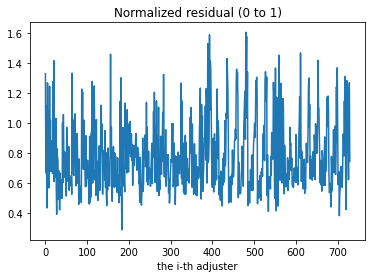

In [125]:
# Load model
filename_si = "model_singular1.sav"
with open(filename_si, "rb") as file:
    model_lr = pickle.load(file)

# print('shape of intercept:', np.shape(model_lr.intercept_))
# print('shape of slope:', np.shape(model_lr.coef_)) 
model_score = model_lr.score(train_input, train_output)
print(f"Model score (from training set) : {model_score}")
model_score = model_lr.score(test_input, test_output)
print(f"Model score (from testing set): {model_score}")

# Make a prediction
predict_output = model_lr.predict(test_input)
# residual_normalized = np.mean(np.square(test_output - predict_output), axis=0)/np.mean(np.square(train_output+test_output), axis=0)
residual_normalized = np.mean(np.square(test_output - predict_output), axis=0)/np.mean(np.square(adj_tot1), axis=0)

# print('shape of predict_output:', np.shape(predict_output)) 
# print('shape of residual:', np.shape(residual_normalized)) 
print('average normalized residual:', np.mean(residual_normalized)) 

import matplotlib.pyplot as plt
plt.title("Normalized residual (0 to 1)")
plt.plot(residual_normalized)
plt.xlabel("the i-th adjuster")
plt.show()

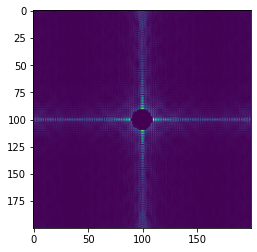

In [197]:
def train_model_holesize_rad(holesize, percent):
    # hole_radius_rad = 4.0/60.0/3.876*50.0*np.pi/180.0
    hole_radius_rad = holesize
    print(f"!!! Hole radius [rad] : {hole_radius_rad} rad-------------------------")
    phases1 = []
    for dat in data1:
        azi = dat[:, 0]
        az = azi
        eli = dat[:, 1]
        el = eli
        beam = dat[:, 2] + 1j * dat[:, 3]
        AZ = np.reshape(az, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
        EL = np.reshape(el, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
        beam = np.reshape(beam, (int(np.sqrt(len(el))), int(np.sqrt(len(el)))))
        beam = np.where((AZ*AZ+(EL-0.007)*(EL-0.007)>hole_radius_rad**2), beam, 0)
        beam_fft = np.fft.fftshift(np.fft.ifft2(beam))
        ampl = np.abs(beam_fft)
        beam_fft = np.where(
            (ampl / np.max(ampl)) >= percent/100.0, beam_fft, 0
            )
        phase = np.angle(np.ravel(beam_fft))
        phase = phase - np.mean(phase)
        # beam_fft = np.where(
        #     (abs(ampl) / np.max(abs(ampl))) >= 0.3, beam_fft, 0
        #     )

        beam_0 = np.where((AZ*AZ+(EL-0.007)*(EL-0.007)>hole_radius_rad**2), beam_sky0, 0)
        # plt.imshow(np.abs(beam_0))
        beam_fft = np.fft.fftshift(np.fft.ifft2(beam_0))
        ampl = np.abs(beam_fft)
        beam_fft = np.where(
            (ampl / np.max(ampl)) >= percent/100.0, beam_fft, 0
            )
        phase_0 = np.angle(np.ravel(beam_fft))
        phase_0 = phase_0 - np.mean(phase_0)
        phase = np.mod(phase - phase_0, 2*np.pi)
        
        # phase = np.angle(np.ravel(beam))
        # phase = np.where(
        #     (abs(ampl) / np.max(abs(ampl))) >= 0.05, phase, 0
        # )
        phases1.append(phase)
    phases1 = np.array(phases1)
    shuffler = np.random.permutation(len(phases1))
    phases1s = np.array(phases1[shuffler])
    adj_tot1s = np.array(adj_tot1[shuffler])

    # set the sizes of training and testing sets
    N_train = int(iters*0.9)
    N_test = iters - N_train

    # Define training datasets
    train_input = phases1s[0 :N_train]
    train_output = adj_tot1s[0 : N_train]
    test_input = phases1s[N_train:]
    test_output = adj_tot1s[N_train:]
    # Train the linear regression ML model
    model_lr = LinearRegression(n_jobs=-1)  # Define ML algorithm
    model_lr.fit(train_input, train_output)  # Train model with training datasets

    model_score = model_lr.score(test_input, test_output)
    print(f"Model score (from testing set): {model_score}")

    # Save the model
    filename_si = f"E:\\Holography\\lat_holocal\\data\\ctcheung\\model\\model_LR_sky_{hole_radius_rad}rad.sav"
    pickle.dump(model_lr, open(filename_si, "wb"))
    print(f"Linear regression model for holesize {hole_radius_rad} trained and saved!")
    return model_score


In [198]:
holes_size_rad = np.array([0.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0, 90.0, 150.0, 240.0, 300.0, 340.0, 360.0, 380.0, 390.0, 395.0, 400.0]) /252.4 /180.0 * np.pi
# holes_size_rad = np.array([0.0])
model_score_rad = np.zeros_like(holes_size_rad)

for ii, hs in enumerate(holes_size_rad):
    model_score = train_model_holesize_rad(hs, 30)
    model_score_rad[ii] = model_score

!!! Hole radius [rad] : 0.0 rad-------------------------
Model score (from testing set): 0.15900716897359815
Linear regression model for holesize 0.0 trained and saved!
!!! Hole radius [rad] : 0.00034574668224927283 rad-------------------------
Model score (from testing set): 0.18849148588357542
Linear regression model for holesize 0.00034574668224927283 trained and saved!
!!! Hole radius [rad] : 0.0006914933644985457 rad-------------------------
Model score (from testing set): -0.2286820476781911
Linear regression model for holesize 0.0006914933644985457 trained and saved!
!!! Hole radius [rad] : 0.0010372400467478185 rad-------------------------
Model score (from testing set): -0.2775857064450584
Linear regression model for holesize 0.0010372400467478185 trained and saved!
!!! Hole radius [rad] : 0.0013829867289970913 rad-------------------------
Model score (from testing set): -0.31319108318061173
Linear regression model for holesize 0.0013829867289970913 trained and saved!
!!! Hole

KeyboardInterrupt: 

Text(0, 0.5, 'score (0 to 1)')

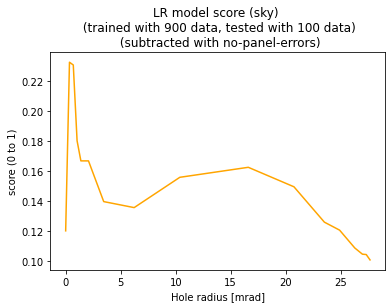

In [ ]:
x = holes_size_rad * 1e3
y = np.where(model_score_rad>0, model_score_rad, 0)
plt.plot(x, y, color="orange")
plt.title("LR model score (sky) \n (trained with 900 data, tested with 100 data)\n (subtracted with no-panel-errors)")
plt.xlabel("Hole radius [mrad]")
plt.ylabel("score (0 to 1)")